In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context = 'notebook', palette = 'deep')

#### Load and Check Data

In [8]:
train = pd.read_csv("C:/Users/jlee0/Desktop/KYU/deep learning/kaggle/Titanic/data/train.csv")
test = pd.read_csv("C:/Users/jlee0/Desktop/KYU/deep learning/kaggle/Titanic/data/test.csv")
IDtest = test["PassengerId"]

#### Outlier detection

In [11]:
def detect_outliers(df,n,features):
# Tukey method를 사용하여 outlier를 판별
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col],25)  #각 col안에서 하위 25%를 뽑는 것
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1  #Interquartile range(IQR) : 사분위수의 범위. 산포도를 의미한다. 상위 25, 하위 25를 제외한 중간 50%의 데이터만을 의미한다.
        outlier_step = 1.5 * IQR  #이상값을 제외한 범위 
        outlier_list_col = df[(df[col]< Q1 - outlier_step) | (df[col]>Q3 + outlier_step)].index  #outlier, |는 or 연산자이다.
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)  #두개 이상의 outliers값들을 갖으면 drop
    
    return multiple_outliers

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [12]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [13]:
#Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)  #reset_index(drop=True) : 인덱스열을 버린다.

#### Joining train and test set

In [15]:
train_len = len(train)
dataset = pd.concat(objs =[train,test],axis=0).reset_index(drop=True)  #train과 test data를 합쳐준다.

train과 test에 같은 수의 feature를 사용하기 위해서 두 데이터를 join했다.

#### Check for null and missing value

In [16]:
#비어있거나 NaNs 값을 NaN으로 채우기
dataset = dataset.fillna(np.nan)

#Null값이 얼마나 있는지 확인
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Survived가 결측가가 많은 이유는 test set에는 Survived가 존재하지 않지만 train과 test를 join하면서 test에도 Survived가 생기고 전부 NaN으로 채워졌기 때문.

In [17]:
#Infos

train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [20]:
# summarize data
train.describe()  #.describe() : 요약 통계량

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### Feature analysis

##### 1.numerical values

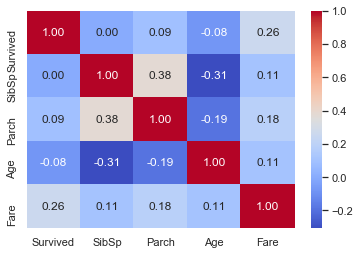

In [21]:
#Correlation matrix between numerical values (SibSp Parch Age Fare) and Survived

g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True,fmt=".2f",cmap="coolwarm")

Survived와는 Fare만 유의미한 관련도를 가지고 있었다.

--> 하지만 단정할 수 없음. 각각 나누어 확인 필요

##### SibSp

C:\Users\jlee0\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\jlee0\anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


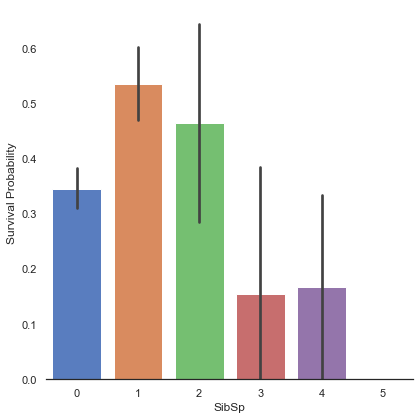

In [24]:
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar",size=6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

##### Parch

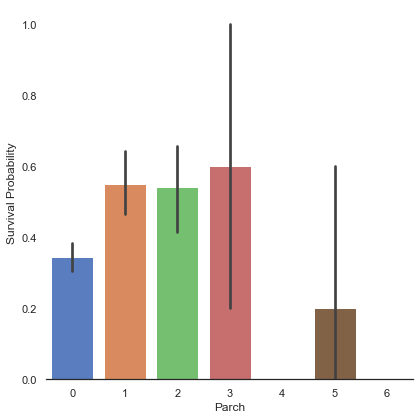

In [27]:
g = sns.factorplot(x="Parch",y="Survived",data = train,kind="bar",size = 6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

##### Age

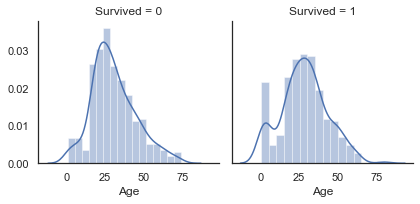

In [28]:
g = sns.FacetGrid(train,col="Survived")  #조건부 관계를 다중으로 그릴수 있는 함수. survived or not을 기준으로 두개의 그래프가 나올 예정
g = g.map(sns.distplot, "Age")

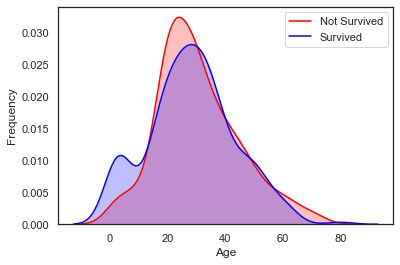

In [32]:
# age 분포에 대한 깊은 비교
g = sns.kdeplot(train["Age"][(train["Survived"]==0)&(train["Age"].notnull())],color="Red",shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"]==1)&(train["Age"].notnull())],color="Blue",shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

##### Fare

In [33]:
dataset["Fare"].isnull().sum()

1

In [34]:
#결측치를 평균값으로 채우기
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

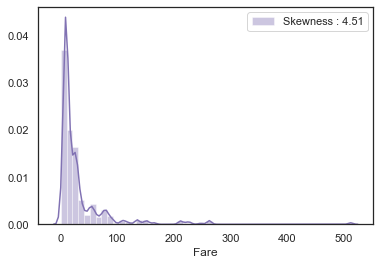

In [37]:
g = sns.distplot(dataset["Fare"],color="m",label="Skewness : %.2f"%(dataset["Fare"].skew()))  #skewness : 비대칭도
g = g.legend(loc = "best")

너무 비대칭도가 크다, overweight문제로 이어질 수 있음 --> log를 취함으로써 비대칭도를 해결한다.

In [40]:
dataset["Fare"] = dataset["Fare"].map(lambda i :  np.log(i) if i > 0 else 0)  #0이상의 모든 값에 log취하기

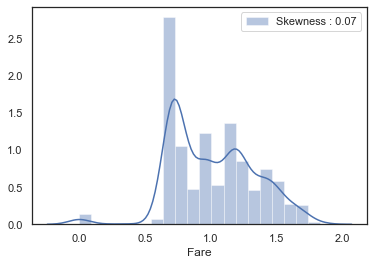

In [41]:
g = sns.distplot(dataset["Fare"],color = "b",label = "Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc = "best")